<a href="https://colab.research.google.com/github/joaosMart/Article-news-prediction/blob/main/Code/species-classification/ResNet_50_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuned ResNET as benchmark

This code implements the benchmark ResNET50 fine-tuned to solve the fish species classification problem.

In [ ]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 100.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
from typing import Dict, Tuple, List
import json
import os
import logging
import glob
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from typing import Dict, Tuple, List
import logging
import pandas as pd

import json
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import numpy as np
from pathlib import Path
from decord import VideoReader
from decord import cpu, gpu
import decord
from tqdm.notebook import tqdm  # Better progress bars for Colab notebooks


In [ ]:
class DataLoader:
    """Handle loading and processing of NPZ files"""
    def __init__(self, data_dir: str):
        self.data_dir = data_dir

    def load_npz_files(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Load all NPZ files from directory and extract averaged_mean features and labels

        Returns:
            features: numpy array of averaged_mean features
            labels: numpy array of fish species labels
        """
        video_path_list = []
        labels_list = []
        central_frames_list = []

        # Get all NPZ files in directory
        npz_files = glob.glob(os.path.join(self.data_dir, "*.npz"))

        logging.info(f"Found {len(npz_files)} NPZ files")

        for npz_file in npz_files:

            try:
                filename = npz_file.split('/')[-1][:-4].split('_')
                riverID = filename[0]
                videoID = filename[1]
                video_path = f"/content/drive/MyDrive/Summer 2023 - fish ML/{riverID}_vid/{videoID}.mp4"
                # Load NPZ file
                data = np.load(npz_file, allow_pickle=True)

                # Extract averaged_mean feature and label
                middle_frame = data['middle_frame'].item()
                fish_species = str(data['fish_species'].item())  # Convert to string


                video_path_list.append(video_path)
                labels_list.append(fish_species)
                central_frames_list.append(middle_frame)

            except Exception as e:
                logging.error(f"Error processing file {npz_file}: {str(e)}")
                continue

        # Convert lists to numpy arrays
        labels_array = np.array(labels_list)

        # Log data distribution
        unique_labels, counts = np.unique(labels_array, return_counts=True)
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(labels_array)) * 100
            logging.info(f"Class {label}: {count} samples ({percentage:.2f}%)")

        return video_path_list, labels_array, central_frames_list


class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return super(NumpyEncoder, self).default(obj)

In [ ]:
data_dir="/content/drive/MyDrive/Master Theses/Feature Extraction/ViT-SO400M-14-SigLIP-mean-frames/"
# Get all NPZ files in directory
npz_files = glob.glob(os.path.join(data_dir, "*.npz"))

logging.info(f"Found {len(npz_files)} NPZ files")

for npz_file in npz_files:
    filename = npz_file.split('/')[-1][:-4].split('_')
    riverID = filename[0]
    videoID = filename[1]
    video_path = f"/content/drive/MyDrive/Summer 2023 - fish ML/{riverID}_vid/{videoID}.mp4"
    "/content/drive/MyDrive/Summer 2023 - fish ML/krossa2019_vid/1.mp4"

print(video_path)

/content/drive/MyDrive/Summer 2023 - fish ML/krossa2022_vid/1233.mp4


In [ ]:
data_loader = DataLoader("/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/Feature Extraction/ViT-SO400M-14-SigLIP")

# Load features and labels
video_paths, species , central_frames= data_loader.load_npz_files()

full_vid_paths = {}

for i, path in enumerate(video_paths):
  full_vid_paths[path] = [central_frames[i], species[i]]

print("Video Paths Number:", len(video_paths))
print("Central Frames Number:", len(central_frames))
print("Species Number:", len(species))

# Print some sample data
print("Central Frames:", central_frames[:3])  # First central frames id's
print("Video Paths:", video_paths[:3])  # First central frames id's

#/content/drive/MyDrive/Summer 2023 - fish ML/krossa2019_vid/1.mp4

Video Paths Number: 3990
Central Frames Number: 3990
Species Number: 3990
Central Frames: [112, 212, 297]
Video Paths: ['/content/drive/MyDrive/Summer 2023 - fish ML/krossa2021_vid/347.mp4', '/content/drive/MyDrive/Summer 2023 - fish ML/krossa2021_vid/785.mp4', '/content/drive/MyDrive/Summer 2023 - fish ML/krossa2021_vid/896.mp4']


In [ ]:
import os
from tqdm import tqdm
import shutil
from pathlib import Path
import decord
from decord import VideoReader
import cv2

def extract_and_save_frames(video_paths_dict: dict, output_dir: str):
    """
    Extract specific frames from videos using Decord and save them organized by class.

    Args:
        video_paths_dict: Dictionary with {video_path: [frame_number, label]}
        output_dir: Directory to save the frames
    """
    # Create output directory
    output_dir = Path(output_dir)
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Create class directories
    labels = set(info[1] for info in video_paths_dict.values())
    for label in labels:
        (output_dir / label).mkdir(exist_ok=True)

    # Process each video
    for video_path, (frame_num, label) in tqdm(video_paths_dict.items(),
                                             desc="Extracting frames"):
        try:
            # Load video with Decord
            vr = VideoReader(video_path)

            # Extract river
            river_name = video_path.split('/')[-2].split('_')[0]

            # Extract frame
            frame = vr[frame_num].asnumpy()

            # Get video name from path
            video_name = Path(video_path).stem

            # Save frame
            frame_path = output_dir / label / f"{river_name}_{video_name}_frame{frame_num}.jpg"
            cv2.imwrite(str(frame_path), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

        except Exception as e:
            print(f"Error processing {video_path}: {str(e)}")
            continue

# Example usage with timing
if __name__ == "__main__":
    import time

    start_time = time.time()

    # Create temp directory on local storage for faster writes
    temp_output_dir = "/content/temp_frames"

    # Extract frames to temp directory
    extract_and_save_frames(
        video_paths_dict=full_vid_paths,
        output_dir=temp_output_dir
    )

    # Move files to final location on Google Drive
    final_output_dir = '/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/ResNet-50-data'
    print("\nMoving files to Google Drive...")
    shutil.copytree(temp_output_dir, final_output_dir, dirs_exist_ok=True)
    shutil.rmtree(temp_output_dir)

    end_time = time.time()
    print(f"\nTotal time: {(end_time - start_time)/60:.2f} minutes")

Extracting frames: 100%|██████████| 3990/3990 [10:34<00:00,  6.29it/s]



Moving files to Google Drive...

Total time: 11.66 minutes


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/ResNet-50-data/Lax')))
print(len(os.listdir('/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/ResNet-50-data/Bleikja')))
print(len(os.listdir('/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/ResNet-50-data/Urriði')))

1229
522
2239


In [ ]:
final_output_dir = '/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/Feature Extraction/ResNet-50'
shutil.copytree("/content/temp_frames", final_output_dir, dirs_exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/temp_frames'

# Extracting data

In [ ]:
import shutil
import os

# Create a local directory for the data
local_data_path = './local_data'
if not os.path.exists(local_data_path):
    print("Copying data from Drive to local storage...")
    shutil.copytree('/content/drive/MyDrive/Summer 2023 - fish ML/Paper - Fish Species Classification/ResNet-50-data', local_data_path)
    print("Copy complete!")

Copying data from Drive to local storage...
Copy complete!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import numpy as np

def train_val_test_split(data_dict, train_ratio=0.8, val_ratio=0.10):
    """
    Split the data into train, validation and test sets
    """
    # Convert dict items to list and shuffle
    items = list(data_dict.items())
    np.random.shuffle(items)

    # Calculate split indices
    n_samples = len(items)
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * val_ratio)

    # Split the data
    train_items = items[:train_size]
    val_items = items[train_size:train_size + val_size]
    test_items = items[train_size + val_size:]

    # Convert back to dictionaries
    train_dict = dict(train_items)
    val_dict = dict(val_items)
    test_dict = dict(test_items)

    return train_dict, val_dict, test_dict

In [ ]:
import torch
import torch.multiprocessing as mp
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import os
import numpy as np
from torch.utils.data._utils.collate import default_collate
import gc
from functools import partial

class FishFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        print("Scanning directories...")
        # Get all valid class directories
        self.classes = sorted([
            d.name for d in self.root_dir.iterdir()
            if d.is_dir() and not d.name.startswith('.')
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Index dataset with progress tracking
        self.samples = []
        print("Indexing dataset...")
        for class_name in tqdm(self.classes, desc="Loading classes"):
            class_dir = self.root_dir / class_name
            image_files = [
                f for f in class_dir.glob('*')
                if f.suffix.lower() in ('.jpg', '.jpeg', '.png')
                and not f.name.startswith('.')
            ]
            self.samples.extend([(str(img_path), class_name) for img_path in image_files])

        print(f"Found {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]

        try:
            with Image.open(img_path) as image:
                image = image.convert('RGB')
            label_idx = self.class_to_idx[class_name]
            return image, label_idx
        except Exception as e:
            print(f"Error reading image {img_path}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))



def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Optimized loader settings for L4 GPU
    num_workers = 0
    loader_kwargs = {
        'num_workers': num_workers,
        'pin_memory': True if torch.cuda.is_available() else False,
        'persistent_workers': True,
        'prefetch_factor': 4,
        'batch_size': batch_size
    }

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        #**loader_kwargs
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        shuffle=False,
        #**loader_kwargs
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=False,
        #**loader_kwargs
    )

    return train_loader, val_loader, test_loader


def main():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        BATCH_SIZE = 128
    else:
        BATCH_SIZE = 32

    # Common preprocessing parameters
    pretrained_size = 224
    pretrained_means = [0.485, 0.456, 0.406]
    pretrained_stds = [0.229, 0.224, 0.225]

    print(f"Using batch size: {BATCH_SIZE}")
    print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

    # Create single dataset instance
    base_dataset = FishFrameDataset(
        root_dir='/content/local_data'
    )

    # Calculate split sizes
    total_size = len(base_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Create indices for splits
    indices = torch.randperm(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create transform datasets
    class TransformSubset(Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            img, label = self.dataset[self.indices[idx]]
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(label)

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(pretrained_size, padding=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
    ])

    # Create split datasets with transforms
    train_dataset = TransformSubset(base_dataset, train_indices, train_transforms)
    val_dataset = TransformSubset(base_dataset, val_indices, eval_transforms)
    test_dataset = TransformSubset(base_dataset, test_indices, eval_transforms)

    return create_data_loaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=BATCH_SIZE
    )

if __name__ == '__main__':
    train_loader, val_loader, test_loader = main()

Using batch size: 128
Device: cuda
Scanning directories...
Indexing dataset...


Loading classes:   0%|          | 0/3 [00:00<?, ?it/s]

Found 3990 images across 3 classes


In [ ]:
def print_directory_structure(startpath):
    """
    Print the directory structure starting from startpath
    """
    print(f"\nDirectory structure of: {startpath}")
    print("-" * 40)

    for root, dirs, files in os.walk(startpath):
        # Get the relative path from the start path
        level = root.replace(startpath, '').count(os.sep)
        indent = '│   ' * level
        print(f"{indent}├── {os.path.basename(root)}/")

        # Print files
        sub_indent = '│   ' * (level + 1)
        for file in files:
            if not file.startswith('.'):  # Skip hidden files
                print(f"{sub_indent}├── {file}")

# Example usage:
import os
print_directory_structure('/content/local_data')


Directory structure of: /content/local_data
----------------------------------------
├── local_data/
│   ├── Lax/
│   │   ├── laxaleir2020_742_frame238.jpg
│   │   ├── krossa2022_563_frame102.jpg
│   │   ├── Sela2022_239_frame266.jpg
│   │   ├── krossa2021_212_frame209.jpg
│   │   ├── laxaleir2022_49_frame5.jpg
│   │   ├── krossa2022_619_frame112.jpg
│   │   ├── laxaleir2020_76_frame211.jpg
│   │   ├── krossa2019_115_frame180.jpg
│   │   ├── krossa2019_153_frame229.jpg
│   │   ├── krossa2021_678_frame206.jpg
│   │   ├── laxaleir2022_809_frame47.jpg
│   │   ├── krossa2020_16_frame212.jpg
│   │   ├── laxaleir2022_62_frame15.jpg
│   │   ├── krossa2022_620_frame143.jpg
│   │   ├── laxaleir2020_1373_frame355.jpg
│   │   ├── laxaleir2020_146_frame338.jpg
│   │   ├── krossa2019_170_frame110.jpg
│   │   ├── laxaleir2022_538_frame10.jpg
│   │   ├── laxaleir2020_1012_frame213.jpg
│   │   ├── laxaleir2022_92_frame20.jpg
│   │   ├── laxaleir2020_1039_frame370.jpg
│   │   ├── krossa2020_44_frame17

In [ ]:
print(f'Number of training examples: {len(train_loader)}')
print(f'Number of validation examples: {len(val_loader)}')
print(f'Number of testing examples: {len(test_loader)}')

Number of training examples: 22
Number of validation examples: 4
Number of testing examples: 7


# Visualisation

In [ ]:
from torch.utils.data import Subset

# Create a small subset with only the first 10 samples
small_dataset = Subset(train_loader.dataset, range(10))

# Fetch samples directly
images, labels = zip(*[small_dataset[i] for i in range(len(small_dataset))])
images = torch.stack(images)
labels = torch.tensor(labels)


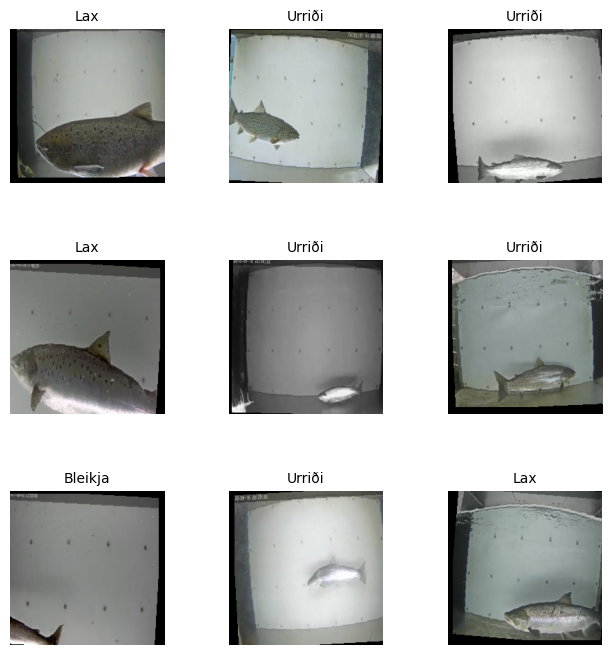

In [ ]:
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization applied to the image.
    Args:
        image: Tensor of shape (C, H, W)
        mean: Mean values used for normalization
        std: Standard deviation values used for normalization
    Returns:
        Denormalized image tensor
    """
    image = image.clone()  # Avoid modifying the original tensor
    for c, m, s in zip(image, mean, std):
        c.mul_(s).add_(m)  # Denormalize channel
    return torch.clamp(image, 0, 1)  # Clamp values to [0, 1]


def plot_images_grid_with_detransform(dataset, num_images=9, grid_size=(3, 3), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Plot images from the dataset in a grid with their transformations undone and labels on top.

    Args:
        dataset: PyTorch Dataset or Subset object
        num_images: Number of images to display
        grid_size: Tuple specifying the grid dimensions (rows, cols)
        mean: Mean values used for normalization
        std: Standard deviation values used for normalization
    """
    rows, cols = grid_size
    assert rows * cols == num_images, "Grid size must match the number of images to display."

    # Access the underlying dataset if the dataset is a Subset
    if hasattr(dataset, "dataset"):
        base_dataset = dataset.dataset
    else:
        base_dataset = dataset

    # Fetch the first `num_images` from the dataset
    images, labels = zip(*[dataset[i] for i in range(num_images)])
    images = [denormalize_image(img, mean, std).permute(1, 2, 0) for img in images]  # Denormalize and convert to HxWxC

    # Map labels to class names using the base dataset's `classes`
    labels = [base_dataset.classes[label] for label in labels]

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)  # Add space for titles

    for i, ax in enumerate(axes.flat):
        img = images[i].numpy()  # Convert tensor to numpy

        ax.imshow(img)
        ax.set_title(labels[i], fontsize=10)
        ax.axis('off')  # Remove axis

    plt.show()

# Example usage
plot_images_grid_with_detransform(train_loader.dataset, num_images=9, grid_size=(3, 3))


# Architecture

In [ ]:
import torch
import torch.nn as nn  # Add this import

class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

In [ ]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [ ]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

# Pre-trained

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
pretrained_model = models.resnet50(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
IN_FEATURES = pretrained_model.fc.in_features
print(IN_FEATURES)
OUTPUT_DIM = 3 # Number of classes hardcoded

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

# Initialize our own ResNet-50 and load the pretrained weights
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

2048


<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,514,179 trainable parameters


# Training

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, train_loader, val_loader, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5):
        """
        Simplified version that works directly with DataLoader
        Handles models that return multiple outputs by taking the first output
        """
        lrs = []
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')

        # Create learning rate scheduler
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        # Create infinite cycle iterators
        train_iter = iter(train_loader)
        val_iter = iter(val_loader)

        # Main training loop
        for iteration in tqdm(range(num_iter), desc='Learning Rate Range Test'):
            try:
                x, y = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                x, y = next(train_iter)

            # Train batch
            self.model.train()
            self.optimizer.zero_grad()
            x = x.to(self.device)
            y = y.to(self.device)

            # Handle model outputs that might be tuples
            outputs = self.model(x)
            y_pred = outputs[0] if isinstance(outputs, tuple) else outputs

            loss = self.criterion(y_pred, y)
            loss.backward()
            self.optimizer.step()
            train_loss = loss.item()

            # Validation batch
            try:
                val_x, val_y = next(val_iter)
            except StopIteration:
                val_iter = iter(val_loader)
                val_x, val_y = next(val_iter)

            self.model.eval()
            with torch.no_grad():
                val_x = val_x.to(self.device)
                val_y = val_y.to(self.device)

                # Handle model outputs that might be tuples
                val_outputs = self.model(val_x)
                val_pred = val_outputs[0] if isinstance(val_outputs, tuple) else val_outputs

                val_loss = self.criterion(val_pred, val_y).item()

            # Update learning rate
            lr_scheduler.step()
            current_lr = lr_scheduler.get_lr()[0]
            lrs.append(current_lr)

            # Smooth the losses
            if iteration > 0:
                train_loss = smooth_f * train_loss + (1 - smooth_f) * train_losses[-1]
                val_loss = smooth_f * val_loss + (1 - smooth_f) * val_losses[-1]

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Check for divergence
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            elif val_loss > diverge_th * best_val_loss:
                print("Stopping early, the validation loss has diverged")
                break

        # Reset model to initial state
        self.model.load_state_dict(torch.load('init_params.pt'))
        return lrs, train_losses, val_losses


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [ ]:
END_LR = 1
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, train_losses, val_losses = lr_finder.range_test(train_loader, val_loader, END_LR, NUM_ITER)

Learning Rate Range Test:  61%|██████    | 61/100 [00:30<00:19,  1.99it/s]

Stopping early, the validation loss has diverged



<ipython-input-23-57ba9437fe8a>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('init_params.pt'))


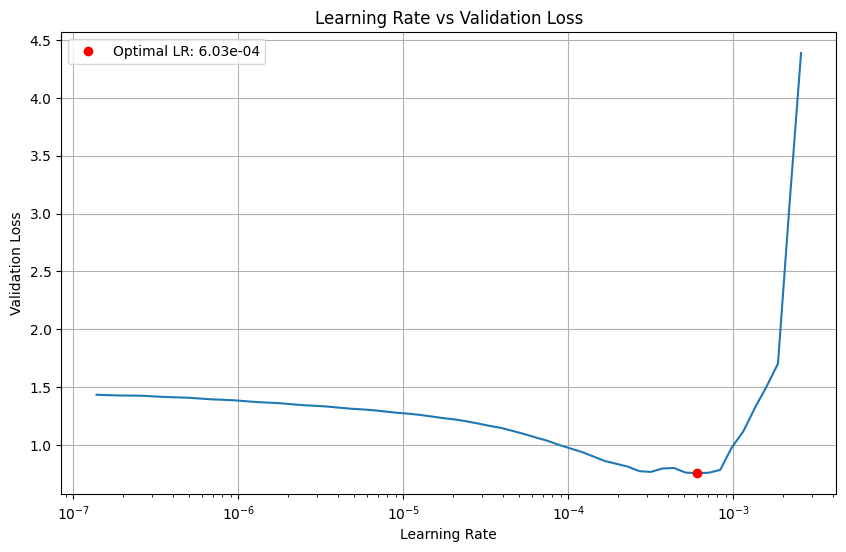

Optimal learning rate: 6.03e-04
Minimum validation loss: 0.7572


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_learning_rates(lrs, val_losses):
    # Convert to numpy arrays for easier manipulation
    lrs = np.array(lrs)
    val_losses = np.array(val_losses)

    # Find the learning rate with minimum validation loss
    min_loss_idx = np.argmin(val_losses)
    optimal_lr = lrs[min_loss_idx]
    min_loss = val_losses[min_loss_idx]

    # Plot the learning rate vs loss curve
    plt.figure(figsize=(10, 6))
    plt.semilogx(lrs, val_losses)
    plt.plot(optimal_lr, min_loss, 'ro', label=f'Optimal LR: {optimal_lr:.2e}')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    plt.title('Learning Rate vs Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    return optimal_lr, min_loss

# Find the optimal learning rate
optimal_lr, min_loss = analyze_learning_rates(lrs, val_losses)
print(f"Optimal learning rate: {optimal_lr:.2e}")
print(f"Minimum validation loss: {min_loss:.4f}")

In [ ]:
FOUND_LR = 6.03e-04

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.3918 | Train Acc: 81.70%
Val Loss: 0.3273 | Val Acc: 91.98%
Validation loss decreased (inf --> 0.327322). Saving model...

Epoch 2/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.1358 | Train Acc: 95.17%
Val Loss: 0.1474 | Val Acc: 95.49%
Validation loss decreased (0.327322 --> 0.147357). Saving model...

Epoch 3/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0806 | Train Acc: 96.99%
Val Loss: 0.1043 | Val Acc: 97.24%
Validation loss decreased (0.147357 --> 0.104350). Saving model...

Epoch 4/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0703 | Train Acc: 97.31%
Val Loss: 0.2100 | Val Acc: 95.49%
EarlyStopping counter: 1 out of 7

Epoch 5/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0667 | Train Acc: 97.57%
Val Loss: 0.1029 | Val Acc: 95.99%
Validation loss decreased (0.104350 --> 0.102923). Saving model...

Epoch 6/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0475 | Train Acc: 98.28%
Val Loss: 0.1154 | Val Acc: 96.24%
EarlyStopping counter: 1 out of 7

Epoch 7/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0311 | Train Acc: 98.89%
Val Loss: 0.0913 | Val Acc: 97.99%
Validation loss decreased (0.102923 --> 0.091345). Saving model...

Epoch 8/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0651 | Train Acc: 98.17%
Val Loss: 0.1241 | Val Acc: 97.99%
EarlyStopping counter: 1 out of 7

Epoch 9/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0486 | Train Acc: 98.25%
Val Loss: 0.1094 | Val Acc: 95.99%
EarlyStopping counter: 2 out of 7

Epoch 10/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0448 | Train Acc: 98.21%
Val Loss: 0.2376 | Val Acc: 96.24%
EarlyStopping counter: 3 out of 7

Epoch 11/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0348 | Train Acc: 99.00%
Val Loss: 0.1252 | Val Acc: 97.24%
EarlyStopping counter: 4 out of 7

Epoch 12/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0197 | Train Acc: 99.00%
Val Loss: 0.1236 | Val Acc: 97.49%
EarlyStopping counter: 5 out of 7

Epoch 13/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0152 | Train Acc: 99.50%
Val Loss: 0.1269 | Val Acc: 97.24%
EarlyStopping counter: 6 out of 7

Epoch 14/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Train Loss: 0.0145 | Train Acc: 99.57%
Val Loss: 0.1231 | Val Acc: 97.49%
EarlyStopping counter: 7 out of 7
Early stopping triggered


<ipython-input-27-022d08756f79>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


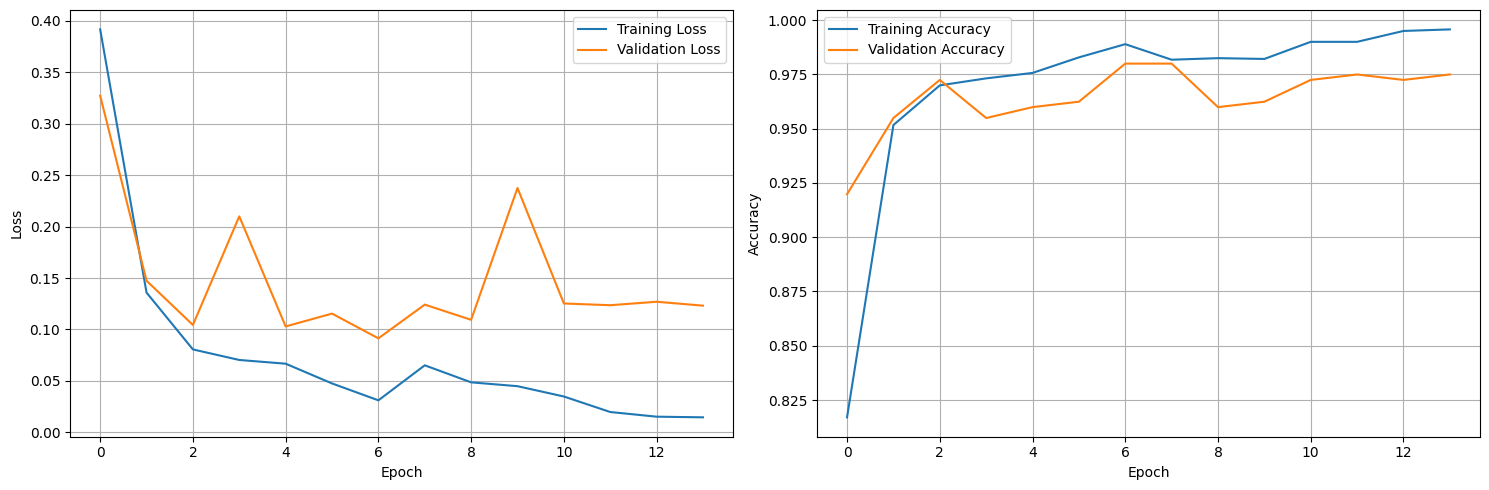

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

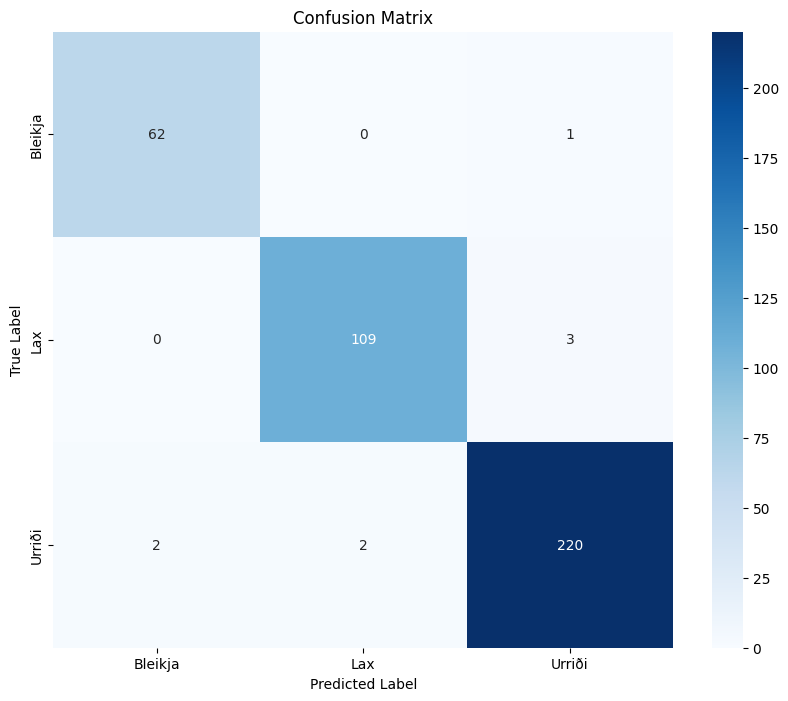


Classification Report:
              precision    recall  f1-score   support

     Bleikja       0.97      0.98      0.98        63
         Lax       0.98      0.97      0.98       112
      Urriði       0.98      0.98      0.98       224

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, path='checkpoint.pt'):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/total, 'acc': 100.*correct/total})

    return running_loss/len(train_loader), correct/total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss/len(val_loader), correct/total, all_preds, all_labels

def plot_metrics(train_losses, val_losses, train_accs, val_accs, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_confusion_matrix(true_labels, predictions, classes, save_path=None):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=50, patience=7, class_names=None):
    # Initialize metrics storage
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print epoch results
        print(f'\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    # Plot training curves
    plot_metrics(train_losses, val_losses, train_accs, val_accs, 'training_curves.png')

    # Plot confusion matrix for the best model
    _, _, final_preds, final_labels = validate_epoch(model, val_loader, criterion, device)
    if class_names:
        plot_confusion_matrix(final_labels, final_preds, class_names, 'confusion_matrix.png')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(final_labels, final_preds,
                              target_names=class_names if class_names else None))

    return model, (train_losses, val_losses, train_accs, val_accs)

def main(model, train_loader, val_loader):  # Added model and data loaders as parameters
    # Your model and optimization parameters
    FOUND_LR = 6.03e-04
    NUM_EPOCHS = 50
    PATIENCE = 7

    # Class names for visualization
    class_names = ['Bleikja', 'Lax', 'Urriði']

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model =  model.to(device)

    # Layer-wise learning rates
    params = [
        {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
        {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
        {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
        {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
        {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
        {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
        {'params': model.fc.parameters()}
    ]

    # Loss function with class weights to handle imbalance
    class_counts = torch.tensor([279, 1086, 1588], dtype=torch.float32)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer and scheduler
    optimizer = optim.Adam(params, lr=FOUND_LR)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Train the model
    trained_model, metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=NUM_EPOCHS,
        patience=PATIENCE,
        class_names=class_names
    )

    return trained_model, metrics

if __name__ == '__main__':
    # You'll need to call main with your model and data loaders
    # trained_model, metrics = main(model, train_loader, val_loader)
    # Assuming you have your model and data loaders already defined
    trained_model, metrics = main(model, train_loader, val_loader)

In [ ]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_kdef calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

SyntaxError: invalid syntax (<ipython-input-29-d303bd373d70>, line 11)

In [ ]:
base_dataset = FishFrameDataset(
        root_dir='/content/local_data'
    )

# Since you've already created base_dataset
print("Classes:", base_dataset.classes)
# To also see the mapping of classes to indices
print("\nClass to index mapping:", base_dataset.class_to_idx)

# To see class distribution
class_counts = {}
for _, class_name in base_dataset.samples:
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Scanning directories...
Indexing dataset...


Loading classes: 100%|██████████| 3/3 [00:00<00:00, 106.71it/s]

Found 3990 images across 3 classes
Classes: ['Bleikja', 'Lax', 'Urriði']

Class to index mapping: {'Bleikja': 0, 'Lax': 1, 'Urriði': 2}

Class distribution:
Bleikja: 522 images
Lax: 1229 images
Urriði: 2239 images


# Learning Curves Plotting and Saving

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import json
import os
import random
from torch.utils.data import Dataset, DataLoader
import gc
from pathlib import Path
from PIL import Image
from torchvision import models, transforms

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, path='checkpoint.pt'):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

# Custom dataset for learning curve with transforms applied
class LearningCurveSubset(Dataset):
    def __init__(self, base_dataset, sample_indices, transform=None):
        self.base_dataset = base_dataset
        self.sample_indices = sample_indices
        self.transform = transform
        self.samples = [base_dataset.samples[i] for i in sample_indices]
        self.classes = base_dataset.classes
        self.class_to_idx = base_dataset.class_to_idx

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]

        try:
            with Image.open(img_path) as image:
                image = image.convert('RGB')

            if self.transform:
                image = self.transform(image)

            label_idx = self.class_to_idx[class_name]
            return image, label_idx
        except Exception as e:
            print(f"Error reading image {img_path}: {str(e)}")
            # Return a different sample if this one fails
            return self.__getitem__((idx + 1) % len(self))

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/total, 'acc': 100.*correct/total})

    return running_loss/len(train_loader), correct/total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss/len(val_loader), correct/total, all_preds, all_labels

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set and calculate F1 score"""
    model.eval()
    all_preds = []
    all_labels = []

    try:
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Evaluation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                _, predicted = outputs.max(1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate macro F1 score
        f1 = f1_score(all_labels, all_preds, average='macro')
        return f1, all_preds, all_labels
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        # Return a default low score in case of error
        return 0.0, [], []

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=50, patience=7, checkpoint_path='checkpoint.pt'):
    """Train model with early stopping"""
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Print epoch results
        print(f'\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        early_stopping(val_loss, model, path=checkpoint_path)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load best model
    try:
        model.load_state_dict(torch.load(checkpoint_path))
    except Exception as e:
        print(f"Warning: Could not load best model checkpoint: {str(e)}")

    return model

def initialize_model(ResNet, resnet50_config, OUTPUT_DIM=3):
    """Initialize a fresh ResNet model"""
    try:
        # Create a pretrained model and modify the final layer
        pretrained_model = models.resnet50(pretrained=True)
        IN_FEATURES = pretrained_model.fc.in_features
        fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
        pretrained_model.fc = fc

        # Initialize custom ResNet and load the pretrained weights
        model = ResNet(resnet50_config, OUTPUT_DIM)
        model.load_state_dict(pretrained_model.state_dict())

        return model
    except Exception as e:
        print(f"Error initializing model: {str(e)}")
        raise

def generate_learning_curve(ResNet, resnet50_config, base_dataset, test_loader,
                           n_iterations=15, n_repeats=10, num_epochs=50, patience=7,
                           batch_size=32, checkpoint_dir='learning_curve_checkpoints',
                           save_path='learning_curve.json'):
    """
    Generate learning curve by training on increasingly larger subsets of data.

    Args:
        ResNet: Your custom ResNet class
        resnet50_config: Configuration for ResNet50
        base_dataset: Your FishFrameDataset instance
        test_loader: DataLoader for the test set
        n_iterations: Number of different training sizes to evaluate
        n_repeats: Number of repeats per size for calculating mean and std
        num_epochs: Maximum epochs per training run
        patience: Early stopping patience
        batch_size: Batch size for training
        checkpoint_dir: Directory to save model checkpoints
        save_path: Path to save learning curve JSON data
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transforms
    pretrained_size = 224
    pretrained_means = [0.485, 0.456, 0.406]
    pretrained_stds = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(pretrained_size, padding=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
    ])

    # Try to load existing results
    try:
        intermediate_path = f"{save_path.rsplit('.', 1)[0]}_intermediate.json"
        if os.path.exists(intermediate_path):
            with open(intermediate_path, 'r') as f:
                existing_data = json.load(f)
                existing_sizes = existing_data.get('train_sizes', [])
                all_scores = existing_data.get('all_scores', [])
                print(f"Loaded existing results for {len(existing_sizes)} sizes")
        else:
            existing_sizes = []
            all_scores = []
    except Exception as e:
        print(f"Could not load existing results: {str(e)}")
        existing_sizes = []
        all_scores = []

    # Calculate training subset sizes
    total_dataset_size = len(base_dataset)
    train_sizes = np.linspace(0.05 * total_dataset_size, total_dataset_size, n_iterations)
    train_sizes = [int(size) for size in train_sizes]

    # Set up loader kwargs
    loader_kwargs = {
        'num_workers': 4,
        'pin_memory': True if torch.cuda.is_available() else False,
        'persistent_workers': True if total_dataset_size > 1000 else False,
        'prefetch_factor': 4,
        'batch_size': batch_size
    }

    # For each training set size
    for i, train_subset_size in enumerate(train_sizes):
        # Skip sizes we've already processed
        if train_subset_size in existing_sizes:
            idx = existing_sizes.index(train_subset_size)
            size_scores = all_scores[idx]
            print(f"\nSkipping size {train_subset_size} (already processed)")
            continue

        print(f"\n{'='*20} Training Size: {train_subset_size}/{total_dataset_size} ({train_subset_size/total_dataset_size:.2%}) {'='*20}")
        size_scores = []

        # Repeat n_repeats times for each size
        for repeat in range(n_repeats):
            print(f"\n{'*'*10} Repeat {repeat+1}/{n_repeats} {'*'*10}")

            # Create unique checkpoint path for this size and repeat
            checkpoint_path = f"{checkpoint_dir}/size_{train_subset_size}_repeat_{repeat}.pt"

            # Check if we have a completed checkpoint
            if os.path.exists(checkpoint_path):
                print(f"Found existing checkpoint for size {train_subset_size}, repeat {repeat}.")
                try:
                    # Initialize model
                    model = initialize_model(ResNet, resnet50_config)
                    model = model.to(device)

                    # Load checkpoint
                    model.load_state_dict(torch.load(checkpoint_path))

                    # Evaluate model
                    f1, _, _ = evaluate_model(model, test_loader, device)
                    size_scores.append(f1)

                    print(f"Test Macro F1 Score (from checkpoint): {f1:.4f}")

                    # Clean up
                    del model
                    torch.cuda.empty_cache()
                    gc.collect()

                    continue
                except Exception as e:
                    print(f"Error loading checkpoint: {str(e)}. Will retrain.")

            try:
                # Initialize a fresh model
                model = initialize_model(ResNet, resnet50_config)
                model = model.to(device)

                # Create stratified sample of indices for this size
                # Using a dictionary to store class-specific indices
                class_samples_dict = {}
                for idx, (_, class_name) in enumerate(base_dataset.samples):
                    if class_name not in class_samples_dict:
                        class_samples_dict[class_name] = []
                    class_samples_dict[class_name].append(idx)

                # Calculate proportional samples for each class
                total_class_count = sum(len(indices) for indices in class_samples_dict.values())
                sample_indices = []

                for class_name, class_indices in class_samples_dict.items():
                    # Calculate proportional samples
                    class_proportion = len(class_indices) / total_class_count
                    class_sample_count = max(1, min(len(class_indices), int(train_subset_size * class_proportion)))

                    # Randomly sample from this class
                    sampled_class_indices = random.sample(class_indices, class_sample_count)
                    sample_indices.extend(sampled_class_indices)

                # Adjust sample to exactly match requested size
                if len(sample_indices) < train_subset_size:
                    # Add more samples if needed
                    remaining = train_subset_size - len(sample_indices)
                    available_indices = [i for i in range(total_dataset_size) if i not in sample_indices]

                    if available_indices:
                        additional = random.sample(available_indices, min(remaining, len(available_indices)))
                        sample_indices.extend(additional)

                elif len(sample_indices) > train_subset_size:
                    # Remove excess samples
                    sample_indices = random.sample(sample_indices, train_subset_size)

                # Create training subset
                train_subset = LearningCurveSubset(base_dataset, sample_indices, train_transforms)

                # Split into training and validation (80/20 split)
                train_size = int(0.8 * len(train_subset))
                val_size = len(train_subset) - train_size

                train_indices = list(range(len(train_subset)))
                random.shuffle(train_indices)

                train_indices, val_indices = train_indices[:train_size], train_indices[train_size:]

                # Create training DataLoader
                train_loader = DataLoader(
                    train_subset,
                    sampler=torch.utils.data.SubsetRandomSampler(train_indices),
                    **loader_kwargs
                )

                # Create validation DataLoader with eval transforms
                val_subset = LearningCurveSubset(
                    base_dataset,
                    [sample_indices[i] for i in val_indices],
                    eval_transforms
                )

                val_loader = DataLoader(
                    val_subset,
                    shuffle=False,
                    **loader_kwargs
                )

                # Set up optimizer with layer-wise learning rates
                FOUND_LR = 3.16e-04
                params = [
                    {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
                    {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
                    {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
                    {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
                    {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
                    {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
                    {'params': model.fc.parameters()}
                ]

                # Class weights for imbalance
                class_counts = torch.tensor([279, 1086, 1588], dtype=torch.float32)
                class_weights = 1.0 / class_counts
                class_weights = class_weights / class_weights.sum()
                class_weights = class_weights.to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)

                # Optimizer and scheduler
                optimizer = optim.Adam(params, lr=FOUND_LR)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

                # Train the model
                model = train_model(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    device=device,
                    num_epochs=num_epochs,
                    patience=patience,
                    checkpoint_path=checkpoint_path
                )

                # Evaluate on test set
                f1, _, _ = evaluate_model(model, test_loader, device)
                size_scores.append(f1)

                print(f"Test Macro F1 Score: {f1:.4f}")

                # Clean up to free memory
                del model, train_loader, val_loader, train_subset, val_subset
                torch.cuda.empty_cache()
                gc.collect()

            except Exception as e:
                print(f"Error in training iteration for size {train_subset_size}, repeat {repeat}: {str(e)}")
                # Add a low score if we failed
                size_scores.append(0.0)

        # Record scores for this size
        all_scores.append(size_scores)
        existing_sizes.append(train_subset_size)

        # Calculate and display statistics so far
        test_scores_mean = [np.mean(scores) for scores in all_scores]
        test_scores_std = [np.std(scores) for scores in all_scores]

        print("\n=== Current Learning Curve Progress ===")
        for j, (size, mean, std) in enumerate(zip(existing_sizes, test_scores_mean, test_scores_std)):
            print(f"Size {size}: Mean F1 = {mean:.4f}, Std = {std:.4f}")

        # Save intermediate results
        intermediate_data = {
            'train_sizes': existing_sizes,
            'test_scores_mean': test_scores_mean,
            'test_scores_std': test_scores_std,
            'all_scores': all_scores
        }

        with open(f"{save_path.rsplit('.', 1)[0]}_intermediate.json", 'w') as f:
            json.dump(intermediate_data, f, indent=2)

    # Calculate final stats
    test_scores_mean = [np.mean(scores) for scores in all_scores]
    test_scores_std = [np.std(scores) for scores in all_scores]

    # Create final learning curve data
    curve_data = {
        'train_sizes': existing_sizes,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    }

    # Save to file
    with open(save_path, 'w') as f:
        json.dump(curve_data, f, indent=2)

    # Plot the learning curve
    plot_learning_curve(curve_data, save_path.replace('.json', '.png'))

    return curve_data

def plot_learning_curve(curve_data, save_path=None):
    """Plot learning curve with error bands"""
    train_sizes = curve_data['train_sizes']
    test_scores_mean = curve_data['test_scores_mean']
    test_scores_std = curve_data['test_scores_std']

    plt.figure(figsize=(10, 6))

    plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Test Macro F1-score')

    # Plot error bands (standard deviation)
    plt.fill_between(
        train_sizes,
        [max(0, mean - std) for mean, std in zip(test_scores_mean, test_scores_std)],
        [min(1, mean + std) for mean, std in zip(test_scores_mean, test_scores_std)],
        alpha=0.1, color='r'
    )

    plt.xlabel('Training Set Size')
    plt.ylabel('Macro F1-score')
    plt.title('Learning Curve')
    plt.grid(True)
    plt.legend(loc='lower right')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Example usage with Google Drive mounting
"""
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import your ResNet model
from your_model_module import ResNet, resnet50_config

# Create the base dataset (only once)
base_dataset = FishFrameDataset(root_dir='/content/local_data')

# Run the learning curve generation
learning_curve = generate_learning_curve(
    ResNet=ResNet,
    resnet50_config=resnet50_config,
    base_dataset=base_dataset,
    test_loader=test_loader,  # Your existing test loader
    batch_size=32,
    n_iterations=15,
    n_repeats=10,
    checkpoint_dir='/content/drive/MyDrive/learning_curve_checkpoints',
    save_path='/content/drive/MyDrive/learning_curve.json'
)
"""

"\n# Mount Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# Import your ResNet model\nfrom your_model_module import ResNet, resnet50_config\n\n# Create the base dataset (only once)\nbase_dataset = FishFrameDataset(root_dir='/content/local_data')\n\n# Get the test loader from your existing setup\n# Make sure your test_loader is using num_workers=0 for stability\ntest_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)\n\n# Run the learning curve generation\nlearning_curve = generate_learning_curve(\n    ResNet=ResNet,\n    resnet50_config=resnet50_config,\n    base_dataset=base_dataset,\n    test_loader=test_loader,  # Your existing test loader\n    batch_size=32,\n    n_iterations=15,\n    n_repeats=10,\n    checkpoint_dir='/content/drive/MyDrive/learning_curve_checkpoints',\n    save_path='/content/drive/MyDrive/learning_curve.json'\n)\n"

In [ ]:
# Create your dataset
base_dataset = FishFrameDataset(root_dir='/content/local_data')

# Run the learning curve generation
learning_curve = generate_learning_curve(
    ResNet=ResNet,
    resnet50_config=resnet50_config,
    base_dataset=base_dataset,
    test_loader=test_loader,
    batch_size=32,
    n_iterations=15,
    n_repeats=10,
    checkpoint_dir='/content/drive/MyDrive/learning_curve_checkpoints',
    save_path='/content/drive/MyDrive/learning_curve.json'
)

Scanning directories...
Indexing dataset...


Loading classes:   0%|          | 0/3 [00:00<?, ?it/s]

Found 3990 images across 3 classes
Using device: cuda

==================== Training Size: 199/3990 (4.99%) ====================

********** Repeat 1/10 **********
Found existing checkpoint for size 199, repeat 0.


Evaluation:   0%|          | 0/798 [00:00<?, ?it/s]

Test Macro F1 Score (from checkpoint): 0.8300

********** Repeat 2/10 **********


TypeError: 'int' object is not callable

In [ ]:
# Create the base dataset
base_dataset = FishFrameDataset(root_dir='/content/local_data')


# Run the learning curve generation
learning_curve = generate_learning_curve(
    ResNet=ResNet,
    resnet50_config=resnet50_config,
    base_dataset=base_dataset,
    test_loader=test_loader,
    batch_size=64,
    n_iterations=15,
    n_repeats=10,
    checkpoint_dir='/content/drive/MyDrive/learning_curve_checkpoints',
    save_path='/content/drive/MyDrive/learning_curve.json'
)

Scanning directories...
Indexing dataset...


Loading classes:   0%|          | 0/3 [00:00<?, ?it/s]

Found 3990 images across 3 classes
Using device: cuda

==================== Training Size: 199/3990 (4.99%) ====================

********** Repeat 1/10 **********
Found existing checkpoint for size 199, repeat 0.
Error loading/evaluating checkpoint: evaluate_model() missing 1 required positional argument: 'class_names'. Retraining.

Epoch 1/50


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]


Train Loss: 0.9768 | Train Acc: 34.59%
Val Loss: 0.8150 | Val Acc: 70.00%
Validation loss decreased (inf --> 0.815021). Saving model...


TypeError: save() got an unexpected keyword argument 'weights_only'

# Evaluation

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from tqdm import tqdm

def evaluate_model(model, test_loader, device, class_names):
    """
    Evaluate model on test set with multiple metrics:
    - Accuracy
    - Weighted F1-score
    - Macro F1-score
    - Per-class F1 scores
    - AUC (One-vs-Rest for multiclass)
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC calculation

    print("Evaluating model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)

            # Get predicted class
            _, predicted = outputs.max(1)

            # Get probabilities for AUC
            probs = torch.softmax(outputs, dim=1)

            # Store predictions, true labels, and probabilities
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    # Calculate mean AUC (one-vs-rest)
    binary_labels = label_binarize(all_labels, classes=range(len(class_names)))
    mean_auc = roc_auc_score(binary_labels, all_probs, average='macro')

    # Print results
    print("\n=== Test Set Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Mean AUC (One-vs-Rest): {mean_auc:.4f}")

    # Print per-class F1 scores
    print("\nPer-class F1 scores:")
    for class_name, f1 in zip(class_names, per_class_f1):
        print(f"{class_name}: {f1:.4f}")

    # Return all metrics as a dictionary
    metrics = {
        'accuracy': accuracy,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
        'mean_auc': mean_auc,
        'per_class_f1': dict(zip(class_names, per_class_f1))
    }

    return metrics

# Example usage
def evaluate_test_set(model, test_loader):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Set class names
    class_names = ['Bleikja', 'Lax', 'Urriði']

    # Evaluate model
    metrics = evaluate_model(model, test_loader, device, class_names)
    return metrics

if __name__ == '__main__':
    # Assuming you have your model and test_loader ready
    # metrics = evaluate_test_set(model, test_loader)
    test_metrics = evaluate_test_set(trained_model, test_loader)

    # Access overall metrics
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Macro F1: {test_metrics['macro_f1']:.4f}")

    # Access per-class F1 scores
    for class_name, f1_score in test_metrics['per_class_f1'].items():
        print(f"F1 score for {class_name}: {f1_score:.4f}")

Evaluating model on test set...


100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


=== Test Set Metrics ===
Accuracy: 0.9549
Weighted F1-score: 0.9549
Macro F1-score: 0.9408
Mean AUC (One-vs-Rest): 0.9858

Per-class F1 scores:
Bleikja: 0.9011
Lax: 0.9562
Urriði: 0.9651
Test Accuracy: 0.9549
Macro F1: 0.9408
F1 score for Bleikja: 0.9011
F1 score for Lax: 0.9562
F1 score for Urriði: 0.9651


## Learning Curve

In [ ]:
%%writefile learning_curve_analyzer.py

Writing learning_curve_analyzer.py


In [ ]:
%%writefile run_learning_curve.py

Overwriting run_learning_curve.py


In [ ]:
!python /content/run_learning_curve.py

Traceback (most recent call last):
  File "/content/run_learning_curve.py", line 9, in <module>
    from data_loader import FishFrameDataset, TransformSubset, create_data_loaders, main as load_data
ModuleNotFoundError: No module named 'data_loader'


In [ ]:
def create_data_splits(dataset, n_splits):
    total_size = len(dataset)
    split_sizes = np.linspace(0.1, 1.0, n_splits)
    split_indices = [np.random.permutation(total_size)[:int(size * total_size)]
                    for size in split_sizes]
    return split_indices, split_sizes

def train_single_split(model, train_loader, val_loader, optimizer, criterion, scheduler, device):
    model.train()
    for epoch in range(5):
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
    return model

def evaluate_macro_f1(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return f1_score(all_labels, all_preds, average='macro')

def generate_learning_curve(model_class, model_params, train_dataset, val_loader,
                          test_loader, optimizer_class, optimizer_params,
                          criterion, n_splits=15, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    split_indices, split_sizes = create_data_splits(train_dataset, n_splits)
    f1_scores = []

    loader_kwargs = {
        'batch_size': batch_size,
        'num_workers': 0,  # Set to 0 to debug worker issues
        'pin_memory': False,
        'persistent_workers': False
    }

    print("Generating learning curve...")
    for i, indices in enumerate(tqdm(split_indices, desc="Training on splits")):
        split_dataset = Subset(train_dataset, indices)
        split_loader = DataLoader(split_dataset, shuffle=True, **loader_kwargs)

        try:
            model = model_class(**model_params).to(device)
            optimizer = optimizer_class(model.parameters(), **optimizer_params)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

            model = train_single_split(
                model, split_loader, val_loader, optimizer, criterion, scheduler, device
            )
            f1_score = evaluate_macro_f1(model, test_loader, device)
            f1_scores.append(f1_score)
            print(f"\nSplit {i+1}/{n_splits} ({split_sizes[i]*100:.1f}% of data) - "
                  f"Macro F1: {f1_score:.4f}")

        except Exception as e:
            print(f"Error in split {i+1}: {str(e)}")
            break
        finally:
            del split_loader, model, optimizer, scheduler
            torch.cuda.empty_cache()
            gc.collect()

    if f1_scores:
        plot_learning_curve(split_sizes[:len(f1_scores)], f1_scores)
    return split_sizes[:len(f1_scores)], f1_scores

In [ ]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score
import gc
from tqdm import tqdm

# Initialize variables
model_params = {'config': resnet50_config, 'output_dim': OUTPUT_DIM}
optimizer_params = {'lr': FOUND_LR}

# Run learning curve generation
split_sizes, f1_scores = generate_learning_curve(
    model_class=ResNet,
    model_params=model_params,
    train_dataset=train_dataset,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer_class=optim.Adam,
    optimizer_params=optimizer_params,
    criterion=criterion
)

NameError: name 'train_dataset' is not defined